# <center> MARS WEATHER DATA SOLUTION </center>

## Project Description
* This project attempts to provide a data driven solution to understanding and predicting mars weather (temperature and UV Radiation).

### Highlights
* Below are some of the things to be done in the notebook
    1. Perform feature engineering on the datasets
    2. Train a Deep learning model for the temperature data prediction using the data, and Decision Tree Classifier for the UV Radiation Prediction
    3. Analyse the performance of the model and where applicable, finetune the model to perform better.
    4. Wrap the different solutions into two functions. <br>
        * Function one will predict the next temperature values given the current or previous values
        * Function two will predict the UV Radiation, given the temperature.

### Understanding the Datasets

* This project would be using one of two datasets for better result. A summary of each dataset would be covered in details below.

####  Dataset 1
* The dataset tagged mars-weather-1 is saved in csv format, which has data on weather conditions on Mars starting from August7, 2012 (represented as Sol 1, up to February 27, 2018 (represented as Sol 1895. The Rover Environmental Monitoring Station (REMS) which is mounted on the Curiosity Rover, measured and transmitted the data (more details about REMS can be found here !https://mars.nasa.gov/msl/spacecraft/instruments/rems/ )

[ Rover Environmental Monitoring Station (REMS) is a weather station on Mars for Curiosity rover contributed by Spain and Finland. REMS measures humidity, pressure, temperature, wind speeds, and ultraviolet radiation on Mars. This Spanish project is led by the Spanish Astrobiology Center and includes the Finnish Meteorological Institute as a partner, contributing pressure and humidity sensors. source: !https://www.kaggle.com/datasets/deepcontractor/mars-rover-environmental-monitoring-station ]

**Attributes Description**

* id - The identification number of a single transmission
* terrestrial_date - The date on Earth (formatted as month/day/year or m/dd/yy).
* ls - The solar longitude or the Mars-Sun angle, measured from the Northern Hemisphere. In the Northern Hemisphere, the spring equinox is when ls = 0. Since Curiosity is in the Southern Hemisphere, the following ls values are of importance:
    • ls = 0: autumnal equinox
    • ls = 90 : winter solstice
    • ls = 180 : spring equinox
    • ls = 270 : summer solstice

* month - The Martian Month. Similarly to Earth, Martian time can be divided into 12 months.
* min_temp - The minimum temperature (in °C) observed during a single Martian sol.
* max_temp - The maximum temperature (in °C) observed during a single Martian sol.
* pressure - The atmospheric pressure (Pa) in Curiosity's location on Mars.
* wind_speed - The average wind speed (m/s) measured in a single sol. Note: Wind Speed data has not be transmitted to Earth since Sol 1485. Missing values are coded as NaN.
* atmo_opacity - Description of the overall weather conditions on Mars for a given sol based on atmospheric opacity (e.g., Sunny).
(source !https://www.kaggle.com/code/imkrkannan/time-series-forecasting-using-keras-cnn )

#### Dataset 2
* This second dataset tagged mars-weather-2 is stored in comma separated values (csv), the weather data contains information about Mars weather conditions from 2012 to 2022. 
* Since the dataset has much more recent data, this will be used instead of the first one

Understanding Mars time and weather.

Full description of the data can be found on this page
(https://www.planetary.org/articles/mars-calendar)

### IMPORT DATA

In [68]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# deep learning frameworks
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RepeatVector as rv, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.tree import DecisionTreeClassifier

#import the scaler 
from sklearn.preprocessing import MinMaxScaler
#import the encoder
from sklearn.preprocessing import OneHotEncoder
#import data splitting framework
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

#other imports
import time
import warnings

#filter warning
warnings.filterwarnings('ignore')

#set model data result for consistency
tf.random.set_seed(4321)

In [2]:
#load the dataset
data1 = pd.read_csv('data/mars-weather-1.csv')
data2 = pd.read_csv('data/mars-weather-2.csv')

In [3]:
#preview the first data
data1.head(10)

,id,terrestrial_date,sol,ls,month,min_temp,max_temp,pressure,wind_speed,atmo_opacity
0,1895,2018-02-27,1977,135,Month 5,-77.0,-10.0,727.0,NaN,Sunny
1,1893,2018-02-26,1976,135,Month 5,-77.0,-10.0,728.0,NaN,Sunny
2,1894,2018-02-25,1975,134,Month 5,-76.0,-16.0,729.0,NaN,Sunny
3,1892,2018-02-24,1974,134,Month 5,-77.0,-13.0,729.0,NaN,Sunny
4,1889,2018-02-23,1973,133,Month 5,-78.0,-18.0,730.0,NaN,Sunny
5,1891,2018-02-22,1972,133,Month 5,-78.0,-14.0,730.0,NaN,Sunny
6,1890,2018-02-21,1971,132,Month 5,-78.0,-13.0,731.0,NaN,Sunny
7,1888,2018-02-20,1970,132,Month 5,-77.0,-16.0,731.0,NaN,Sunny
8,1887,2018-02-19,1969,131,Month 5,-76.0,-16.0,732.0,NaN,Sunny
9,1886,2018-02-18,1968,131,Month 5,-76.0,-19.0,732.0,NaN,Sunny


In [4]:
#preview the second data
data2.head(10)

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
0,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
1,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
2,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,Value not available,Value not available,05:25,17:21,moderate,Sunny
3,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,Value not available,Value not available,05:26,17:21,moderate,Sunny
4,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,Value not available,Value not available,05:26,17:21,moderate,Sunny
5,"Earth, 2022-01-21 UTC","Mars, Month 6 - LS 161°",Sol 3363,-8,-71,8,-80,707,Value not available,Value not available,05:26,17:21,moderate,Sunny
6,"Earth, 2022-01-20 UTC","Mars, Month 6 - LS 160°",Sol 3362,-4,-72,5,-84,706,Value not available,Value not available,05:26,17:21,moderate,Sunny
7,"Earth, 2022-01-19 UTC","Mars, Month 6 - LS 160°",Sol 3361,-6,-70,5,-73,705,Value not available,Value not available,05:26,17:21,moderate,Sunny
8,"Earth, 2022-01-18 UTC","Mars, Month 6 - LS 159°",Sol 3360,-6,-71,3,-89,707,Value not available,Value not available,05:27,17:21,moderate,Sunny
9,"Earth, 2022-01-17 UTC","Mars, Month 6 - LS 158°",Sol 3359,-9,-71,5,-80,708,Value not available,Value not available,05:27,17:21,moderate,Sunny


In [5]:
# see how the tail looks
data1.tail(10)

,id,terrestrial_date,sol,ls,month,min_temp,max_temp,pressure,wind_speed,atmo_opacity
1884,79,2012-08-23,17,159,Month 6,-76.0,-4.0,742.0,NaN,Sunny
1885,68,2012-08-22,16,158,Month 6,-77.0,0.0,740.0,NaN,Sunny
1886,57,2012-08-21,15,158,Month 6,-78.0,-15.0,740.0,NaN,Sunny
1887,46,2012-08-20,14,157,Month 6,-74.0,-16.0,740.0,NaN,Sunny
1888,35,2012-08-19,13,157,Month 6,-74.0,-15.0,732.0,NaN,Sunny
1889,24,2012-08-18,12,156,Month 6,-76.0,-18.0,741.0,NaN,Sunny
1890,13,2012-08-17,11,156,Month 6,-76.0,-11.0,740.0,NaN,Sunny
1891,2,2012-08-16,10,155,Month 6,-75.0,-16.0,739.0,NaN,Sunny
1892,232,2012-08-15,9,155,Month 6,NaN,NaN,NaN,NaN,Sunny
1893,1,2012-08-07,1,150,Month 6,NaN,NaN,NaN,NaN,Sunny


In [6]:
# do the same for the second datasets
data2.tail(10)

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
3187,"Earth, 2012-08-23 UTC","Mars, Month 6 - LS 159°",Sol 17,-4,-76,7,-81,742,Value not available,Value not available,05:27,17:21,very_high,Sunny
3188,"Earth, 2012-08-22 UTC","Mars, Month 6 - LS 158°",Sol 16,0,-77,9,-81,740,Value not available,Value not available,05:27,17:21,very_high,Sunny
3189,"Earth, 2012-08-21 UTC","Mars, Month 6 - LS 158°",Sol 15,-15,-78,8,-82,740,Value not available,Value not available,05:27,17:21,very_high,Sunny
3190,"Earth, 2012-08-20 UTC","Mars, Month 6 - LS 157°",Sol 14,-16,-74,9,-82,740,Value not available,Value not available,05:27,17:21,very_high,Sunny
3191,"Earth, 2012-08-19 UTC","Mars, Month 6 - LS 157°",Sol 13,-15,-74,8,-80,732,Value not available,Value not available,05:28,17:21,very_high,Sunny
3192,"Earth, 2012-08-18 UTC","Mars, Month 6 - LS 156°",Sol 12,-18,-76,8,-82,741,Value not available,Value not available,05:28,17:21,very_high,Sunny
3193,"Earth, 2012-08-17 UTC","Mars, Month 6 - LS 156°",Sol 11,-11,-76,9,-83,740,Value not available,Value not available,05:28,17:21,very_high,Sunny
3194,"Earth, 2012-08-16 UTC","Mars, Month 6 - LS 155°",Sol 10,-16,-75,8,-83,739,Value not available,Value not available,05:28,17:22,very_high,Sunny
3195,"Earth, 2012-08-15 UTC","Mars, Month 6 - LS 155°",Sol 9,Value not available,Value not available,Value not available,Value not available,Value not available,Value not available,Value not available,05:28,17:22,NaN,Sunny
3196,"Earth, 2012-08-07 UTC","Mars, Month 6 - LS 150°",Sol 1,Value not available,Value not available,Value not available,Value not available,Value not available,Value not available,Value not available,05:30,17:22,NaN,Sunny


## <center> DATA WRANGLING </center>

#### Observation
* The first data seems to have undergone some preparations and these prep made a distinct difference in the second dataset, as can be seen with how missing data were represented.

* use string replacement to resolve the missing data representation.

In [7]:
#apply the replace function
data2 = data2.replace(r'Value not available', np.NaN, regex=True)
#preview the result
data2.tail(10)

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
3187,"Earth, 2012-08-23 UTC","Mars, Month 6 - LS 159°",Sol 17,-4,-76,7,-81,742,NaN,NaN,05:27,17:21,very_high,Sunny
3188,"Earth, 2012-08-22 UTC","Mars, Month 6 - LS 158°",Sol 16,0,-77,9,-81,740,NaN,NaN,05:27,17:21,very_high,Sunny
3189,"Earth, 2012-08-21 UTC","Mars, Month 6 - LS 158°",Sol 15,-15,-78,8,-82,740,NaN,NaN,05:27,17:21,very_high,Sunny
3190,"Earth, 2012-08-20 UTC","Mars, Month 6 - LS 157°",Sol 14,-16,-74,9,-82,740,NaN,NaN,05:27,17:21,very_high,Sunny
3191,"Earth, 2012-08-19 UTC","Mars, Month 6 - LS 157°",Sol 13,-15,-74,8,-80,732,NaN,NaN,05:28,17:21,very_high,Sunny
3192,"Earth, 2012-08-18 UTC","Mars, Month 6 - LS 156°",Sol 12,-18,-76,8,-82,741,NaN,NaN,05:28,17:21,very_high,Sunny
3193,"Earth, 2012-08-17 UTC","Mars, Month 6 - LS 156°",Sol 11,-11,-76,9,-83,740,NaN,NaN,05:28,17:21,very_high,Sunny
3194,"Earth, 2012-08-16 UTC","Mars, Month 6 - LS 155°",Sol 10,-16,-75,8,-83,739,NaN,NaN,05:28,17:22,very_high,Sunny
3195,"Earth, 2012-08-15 UTC","Mars, Month 6 - LS 155°",Sol 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05:28,17:22,NaN,Sunny
3196,"Earth, 2012-08-07 UTC","Mars, Month 6 - LS 150°",Sol 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05:30,17:22,NaN,Sunny


* from the data description, wind speed was said to not have data since sol 1485 because it was not transmitted.  

In [8]:
# preview unique values in the identified column
data1['wind_speed'].unique()

array([nan])

In [9]:
data2['wind_speed(m/h)'].unique()

array([nan])

* Preliminary findings showed that the wind speed and humidity columns does not hold any data that will be useful for this analysis, therefore they will be dropped from the columns.

* Secondly, since the second dataset offers a much more up to date data about Mars planet, the data will be used for this analysis. 

In [10]:
# using the second dataset for the analysis
df = data2.copy()

#drop the specified columns
df = df.drop(['wind_speed(m/h)', 'humidity(%)'], axis=1)
df.head()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation,weather
0,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,05:25,17:20,moderate,Sunny
1,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,05:25,17:20,moderate,Sunny
2,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,05:25,17:21,moderate,Sunny
3,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,05:26,17:21,moderate,Sunny
4,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,05:26,17:21,moderate,Sunny


### Preprocess the new data

* The new data will be processed to reflect a similar structure to the old one, for better visualisation and modelling.

* The following columns will be selected and worked on 

1. earth date time - To extract the datetime from the string
2. mars date time - to extract the solar longitude, which is a measurement with where the planet is in relationship to the sun, and also create a new column called mars month from this column.
3. solar number - To extract the integer representation of solar expedition, which represents each Martian day from the start of the mission

* All of these would be achieved using regular expression library in python.

In [11]:
#starting from the first column, then convert to pandas datetime object
df['earth_date_time'] = pd.to_datetime(df['earth_date_time'].apply(lambda x : re.findall(r'(\d+[-]?\d+[-]?\d+)', x)[0]))

In [12]:
# second column
df['month'] = df['mars_date_time'].apply(lambda x : re.findall(r'([M|m]?onth\s\d)', x)[0].split(' ')[-1]).astype('int64')
df['mars_date_time'] = df['mars_date_time'].apply(lambda x : re.findall(r'(\d*\d)', x)[-1]).astype('int64')

In [13]:
#third column
df['sol_number'] = df['sol_number'].apply(lambda x : re.findall(r'(\d*\d+)', x)[0]).astype('int64')

In [14]:
#preview the result
df.head()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation,weather,month
0,2022-01-26,163,3368,-3,-71,10,-84,707,05:25,17:20,moderate,Sunny,6
1,2022-01-25,163,3367,-3,-72,10,-87,707,05:25,17:20,moderate,Sunny,6
2,2022-01-24,162,3366,-4,-70,8,-81,708,05:25,17:21,moderate,Sunny,6
3,2022-01-23,162,3365,-6,-70,9,-91,707,05:26,17:21,moderate,Sunny,6
4,2022-01-22,161,3364,-7,-71,8,-92,708,05:26,17:21,moderate,Sunny,6


* Rename some columns to reflect easy to use column names

In [15]:
#rename columns
df.rename({'earth_date_time':'earth_date', 'mars_date_time':'ls', 'sol_number':'sol'}, axis=1, inplace=True)

In [16]:
df.columns

Index(['earth_date', 'ls', 'sol', 'max_ground_temp(°C)', 'min_ground_temp(°C)',
       'max_air_temp(°C)', 'min_air_temp(°C)', 'mean_pressure(Pa)', 'sunrise',
       'sunset', 'UV_Radiation', 'weather', 'month'],
      dtype='object')

In [17]:
#rearrange the columns
df = df[['earth_date', 'ls', 'sol', 'month', 'max_ground_temp(°C)', 'min_ground_temp(°C)',
       'max_air_temp(°C)', 'min_air_temp(°C)', 'mean_pressure(Pa)',
       'sunrise', 'sunset', 'UV_Radiation','weather']]
df.head()

,earth_date,ls,sol,month,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation,weather
0,2022-01-26,163,3368,6,-3,-71,10,-84,707,05:25,17:20,moderate,Sunny
1,2022-01-25,163,3367,6,-3,-72,10,-87,707,05:25,17:20,moderate,Sunny
2,2022-01-24,162,3366,6,-4,-70,8,-81,708,05:25,17:21,moderate,Sunny
3,2022-01-23,162,3365,6,-6,-70,9,-91,707,05:26,17:21,moderate,Sunny
4,2022-01-22,161,3364,6,-7,-71,8,-92,708,05:26,17:21,moderate,Sunny


#### MISSING DATA

In [18]:
#missing data across the whole data
df.isna().sum()

earth_date              0
ls                      0
sol                     0
month                   0
max_ground_temp(°C)    28
min_ground_temp(°C)    28
max_air_temp(°C)       29
min_air_temp(°C)       29
mean_pressure(Pa)      27
sunrise                 0
sunset                  0
UV_Radiation           27
weather                 3
dtype: int64

In [19]:
# total length of the dataframe
len(df)

3197

In [20]:
#md is missing data
md = df.isna().sum().max()

#tl is total length
tl = len(df)

#mdp is missing data percentage
mdp = round((md/tl)*100, 1)

print('The percentage of missing data is', mdp, '%')

The percentage of missing data is 0.9 %


* Given that the missing data is not even up to 1% of the whole data, the most suitable approach would be to drop them. 

In [21]:
#drop missing data
df.dropna(inplace=True)

#check if the dropna was effected
df.isna().sum()

earth_date             0
ls                     0
sol                    0
month                  0
max_ground_temp(°C)    0
min_ground_temp(°C)    0
max_air_temp(°C)       0
min_air_temp(°C)       0
mean_pressure(Pa)      0
sunrise                0
sunset                 0
UV_Radiation           0
weather                0
dtype: int64

### FURTHER DATA WRANGLING

* The following operations would be done using the data
    1. Calculate the duration of sunlight time across the data
    2. Calculate the seasons, given the guide from the image attached
    3. Calculate the number of years covered in the dataset using the provided source

In [22]:
# using the sunset and sunrise columns to calculate the total number of hours of sunlight
df['sunlight_duration'] = round(df['sunset'].str.replace(':', '.').astype('float32') - df['sunrise'].str.replace(':', '.').astype('float32'), 2)

* Calculate MARS seasons using the longitudinal solar data

<img src='mars-seasonal-longitudes.jpg'>

* Given the image above, the Spring falls in between 0 to 89 ls and so forth.
* Create a new column for the seasons

In [23]:
# Apply the season filter
df['seasons'] = df['ls'].apply(lambda x: 'Spring' if x <= 89 else ('Summer' if x >= 90 and x <= 179 else ('Autumn (fall)' if x >= 180 and x <= 269 else ('Winter' if x >= 270 and x <= 359 else ''))))
df.head()

,earth_date,ls,sol,month,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation,weather,sunlight_duration,seasons
0,2022-01-26,163,3368,6,-3,-71,10,-84,707,05:25,17:20,moderate,Sunny,11.95,Summer
1,2022-01-25,163,3367,6,-3,-72,10,-87,707,05:25,17:20,moderate,Sunny,11.95,Summer
2,2022-01-24,162,3366,6,-4,-70,8,-81,708,05:25,17:21,moderate,Sunny,11.96,Summer
3,2022-01-23,162,3365,6,-6,-70,9,-91,707,05:26,17:21,moderate,Sunny,11.95,Summer
4,2022-01-22,161,3364,6,-7,-71,8,-92,708,05:26,17:21,moderate,Sunny,11.95,Summer


In [24]:
# preview the unique values in the season columns
df['seasons'].unique()

array(['Summer', 'Spring', 'Winter', 'Autumn (fall)'], dtype=object)

In [25]:
df[df['sol'] <= df['sol'].min()]

,earth_date,ls,sol,month,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation,weather,sunlight_duration,seasons
3194,2012-08-16,155,10,6,-16,-75,8,-83,739,05:28,17:22,very_high,Sunny,11.94,Summer


* Given that the sol column starts from 10 in the earth year of 2012, and also given that the yearly calendar of the planet is almost twice of that of planet earth.
* Will be using the suggestion from (https://www.planetary.org/articles/mars-calendar), the distinguishing of the years on mars is as follows

    1. (0 - 350) as "Year 31",
    2. (351 - 1018) as "Year 32",
    3. (1019 - 1687) as "Year 33",
    4. (1688 - 2356) as "Year 34",
    5. (2357 - 3023) as "Year 35",
    6. (3024 - 3368) as "Year 36"

* Create the mars_year column

In [26]:
# Apply the mars year filter
df['mars_year'] = df['sol'].apply(lambda x: 'Year 31' if x <= 350 else \
                               ('Year 32' if x >= 351 and x <= 1018 else \
                                ('Year 33' if x >= 1019 and x <= 1687 else \
                                 ('Year 34' if x >= 1688 and x <= 2356 else \
                                 ('Year 35' if x >= 2357 and x <= 3023 else \
                                 ('Year 36' if x >= 3024 and x <= 3368 else ''))))))
df.head()

,earth_date,ls,sol,month,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation,weather,sunlight_duration,seasons,mars_year
0,2022-01-26,163,3368,6,-3,-71,10,-84,707,05:25,17:20,moderate,Sunny,11.95,Summer,Year 36
1,2022-01-25,163,3367,6,-3,-72,10,-87,707,05:25,17:20,moderate,Sunny,11.95,Summer,Year 36
2,2022-01-24,162,3366,6,-4,-70,8,-81,708,05:25,17:21,moderate,Sunny,11.96,Summer,Year 36
3,2022-01-23,162,3365,6,-6,-70,9,-91,707,05:26,17:21,moderate,Sunny,11.95,Summer,Year 36
4,2022-01-22,161,3364,6,-7,-71,8,-92,708,05:26,17:21,moderate,Sunny,11.95,Summer,Year 36


In [27]:
df['mars_year'].unique()

array(['Year 36', 'Year 35', 'Year 34', 'Year 33', 'Year 32', 'Year 31'],
      dtype=object)

### VISUALIZING THE DATA FOR MORE INSIGHT
* Given that the focus of this research work is to find out the likeliness of man living on planet mars, it is imperative to visualize the different weather patterns for different temperature (air and ground temperature), and also the UV radiation level obtainable per time.
* So therefore, the visuals would include the temperature columns, and uv radiation column.

<AxesSubplot: >

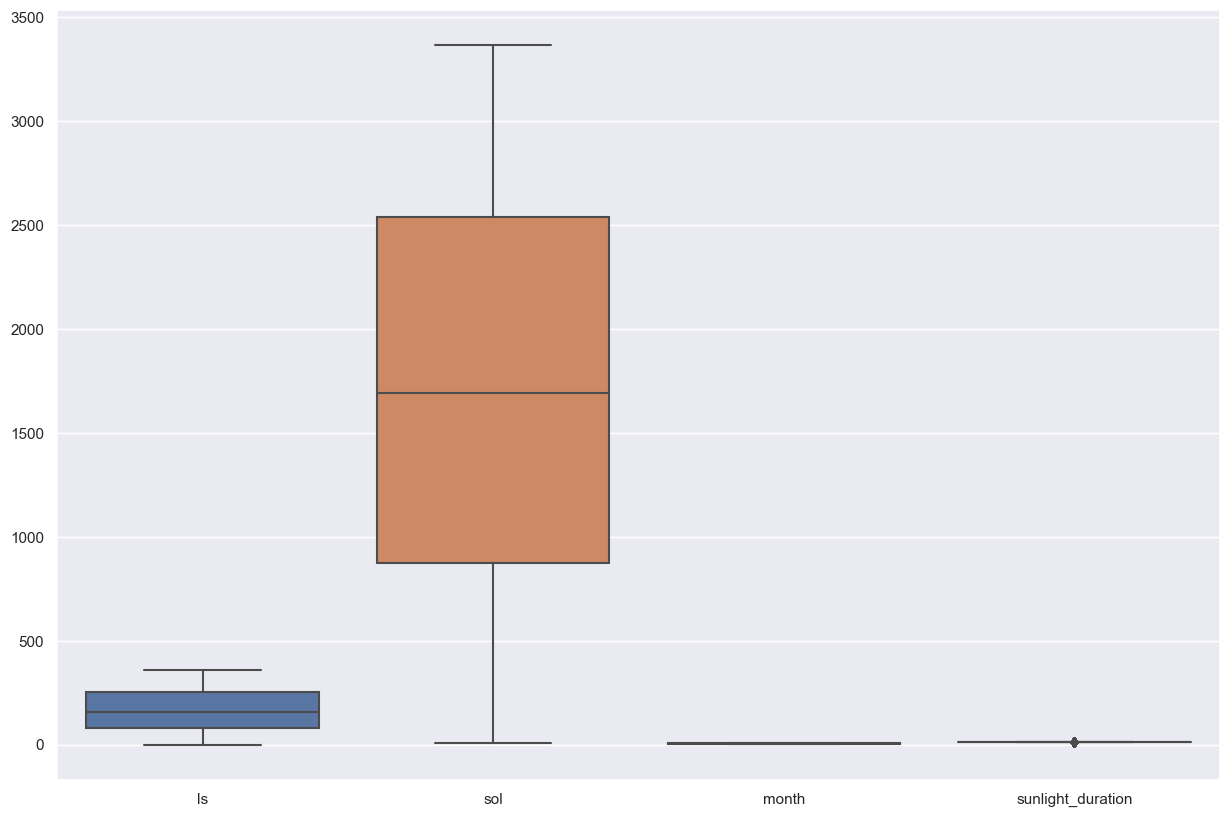

In [28]:
# Set the figure size
sns.set(rc={'figure.figsize': (15, 10)})
 
# Box plot to show the distribution of all the numerical columns in the data
sns.boxplot(data=df.select_dtypes(include='number'))

* Boxplots is a useful in revealing presence of outliers in a data, to help determine how to handle these outliers earlier on in the analysis being carried out and outliers help to reveal unusual occurences or mistakes in the data.
* From the plot above, there are no noticable outliers in the data. This absence of outliers shows that the data is suitable for the analysis that will be done.

### **TEMPERATURE**

In [29]:
#select the plot data (x axes) and the y axis data
selected_columns = list(df.columns[4:9])

# Given that the selected columns are all integers, convert their datatype to int64
for i in selected_columns:
    df[i] = df[i].astype('int64')

#select the y column
y_cols = list(df.columns[-1:])
y_data = df[y_cols]

In [30]:
#define a function to plot the data

def plotData(data, sel_cols, y_axis_col, fig_size=(15, 45), plot_type='density'):
    #set the plot figure size
    plt.figure(figsize=fig_size)
    cols = sel_cols
    
    if plot_type=='density':
        for i in range(len(cols)):
            #subplots
            plt.subplot(16, 1, i+1)
            sns.kdeplot(data=data, x=cols[i], hue=y_axis_col)
            sns.displot(data[cols[i]], kde_kws={"color": "r", "lw": 1, "label": "KDE"})#, hist_kws={"color": "g"})
    elif plot_type == 'full':
        for i in cols[:-1]:
            plt.plot(data['earth_date'], data[i])
            plt.legend(cols[:-1])
        
    plt.tight_layout()

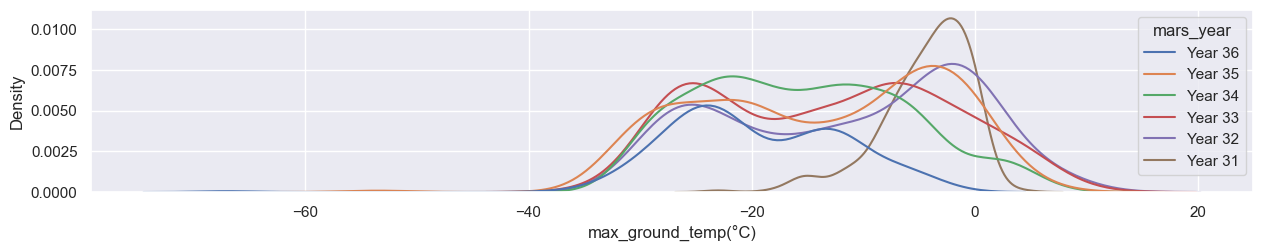

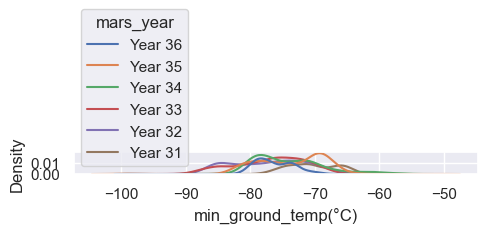

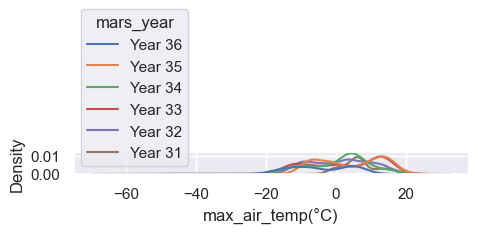

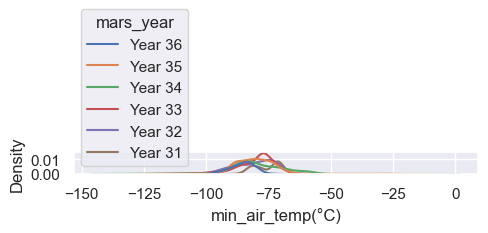

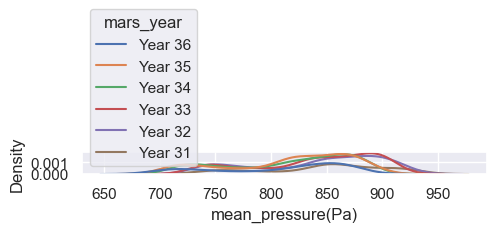

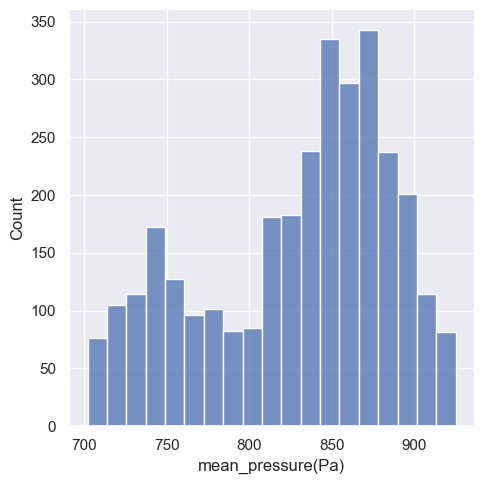

In [31]:
#plot the density level of the dataset
plotData(df, selected_columns, y_cols[0])

* The first plot showed the intersection of different maximum ground temperature across different mars years recorded in the dataset. The highest maximum ground temperature was noticed in the year 31, while other years showed a more steady maximum ground temperature.
* The mean pressure plot showed that average pressure that ranges from 830 to almost 900 seems to be the prevalent kind of pressure obtainable on planet Mars.  

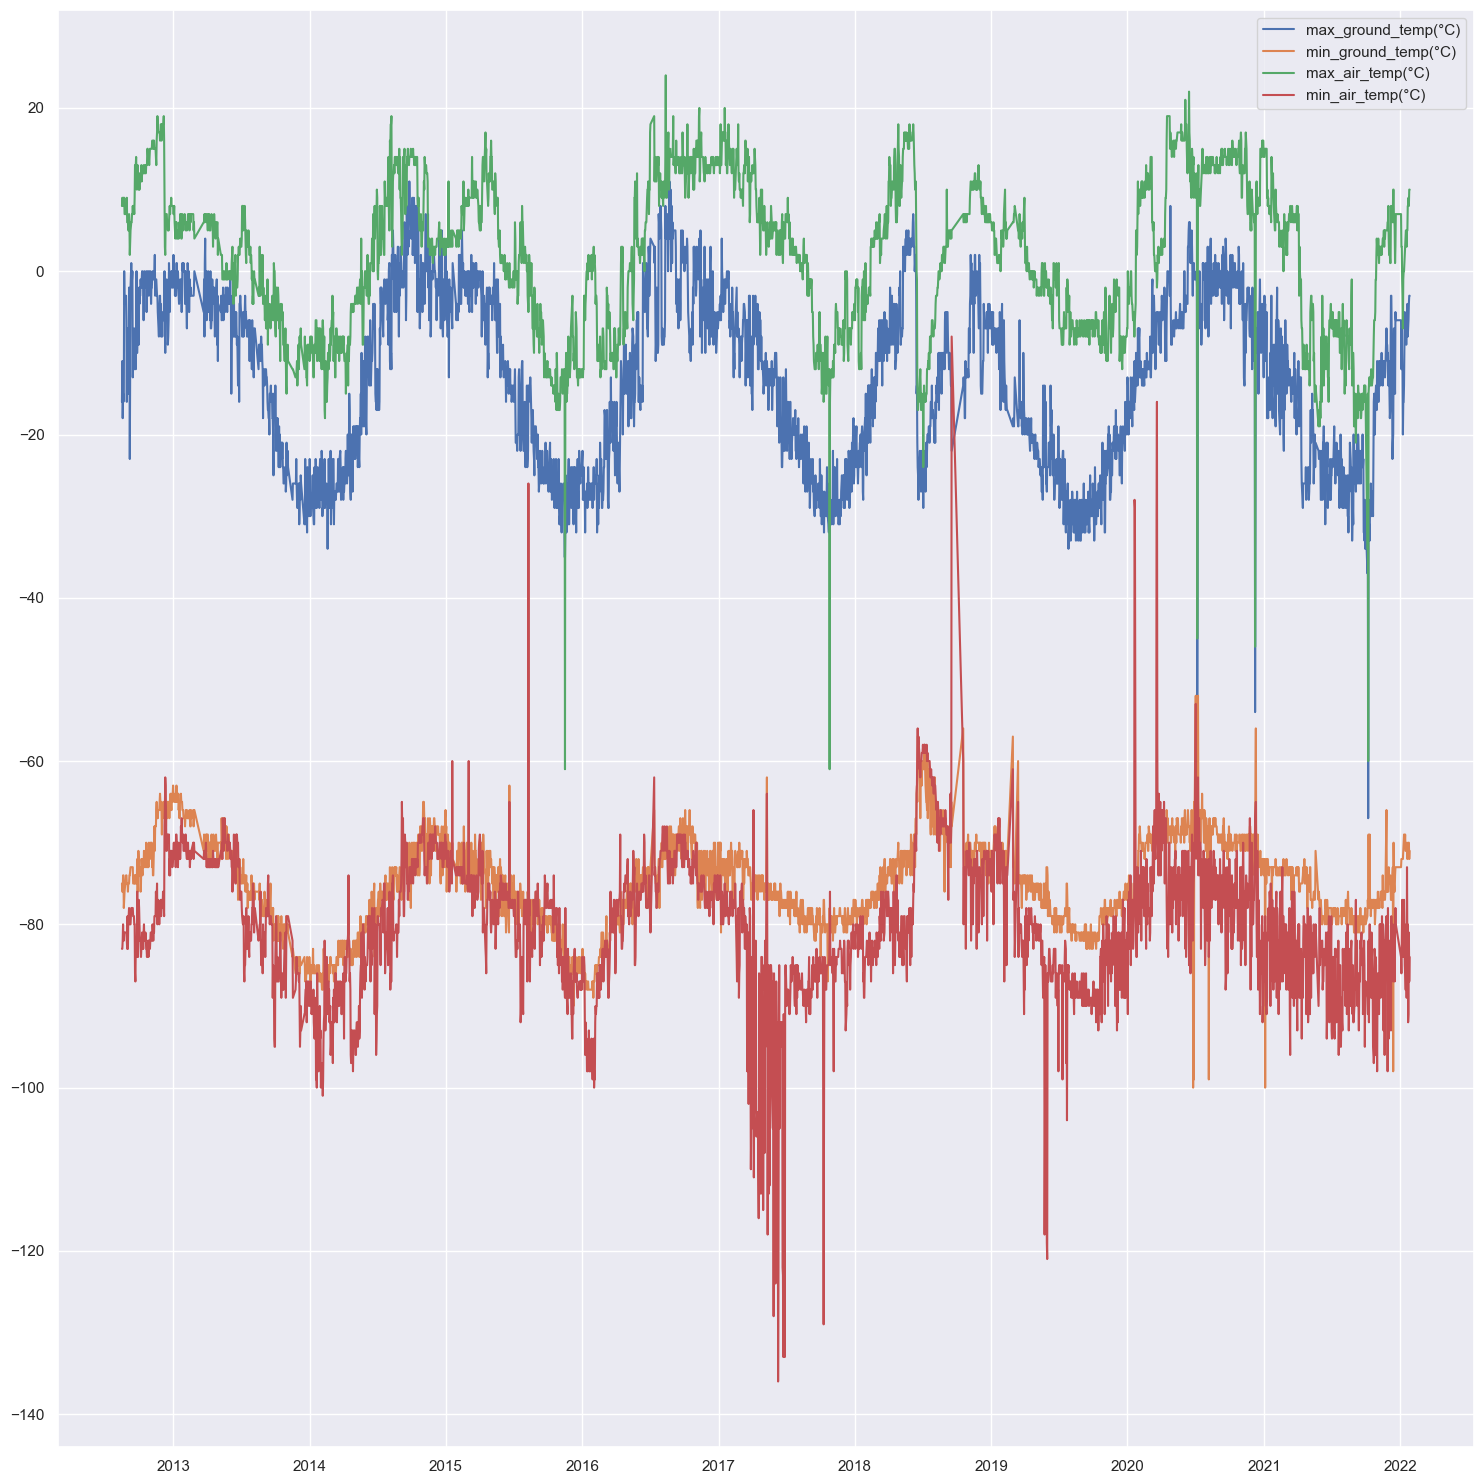

In [32]:
#plot the full plot
plotData(df, selected_columns, y_cols, fig_size=(15,15), plot_type='full')

* The plot showed a wave-length pattern of relationship between dates and the different temperature selected. with which is a sign of predictable seasonality of the range of both ground and air temperature on planet Mars.
* With this observed pattern it makes it fairly possible to predict the likely temperature on planet Mars.

Ultraviolet (UV) radiation covers the wavelength range of 100–400 nm, which is a higher frequency and lower wavelength than visible light. UV radiation comes naturally from the sun, but it can also be created by artificial sources used in industry, commerce and recreation.

The UV region covers the wavelength range 100-400 nm and is divided into three bands:

UVA (315-400 nm)
UVB (280-315 nm)
UVC (100-280 nm).
As sunlight passes through the atmosphere, all UVC and approximately 90% of UVB radiation is absorbed by ozone, water vapour, oxygen and carbon dioxide. UVA radiation is less affected by the atmosphere. Therefore, the UV radiation reaching the Earth’s surface is largely composed of UVA with a small UVB component.

The amount of UV radiation from the sun that hits the Earth’s surface depends on several factors, including the sun’s height in the sky, latitude, cloud cover, altitude, the thickness of the ozone layer and ground reflection. Reductions in the ozone layer due to human-created pollution increase the amount of UVA and UVB that reaches the surface. This can impact human health, animals, marine organisms and plant life. In humans, increased UV exposure can cause skin cancers, cataracts and immune system damage.

### **UV RADIATION**


* UV Radiation are emitted by the sun which is a higher frequency and lower wavelenght than visible light, so it can't be seen with the human eyes, which over exposure could have serious health implications.

* The UV region covers the wavelength range of from 100 to 400 nm and is classified into three bands:
    1. UVA (315-400 nm)
    2. UVB (280-315 nm)
    3. UVC (100-280 nm).

* Ozone, water vapour, oxygen, and carbon dioxide absorb all UVC and about 90% of UVB radiation as it travels through the atmosphere. UVA radiation is less impacted by the climate. As a result, the UV radiation that reaches the Earth's surface mostly consists of UVA and a small amount of UVB.
<br>
* Analyze the UV Radiation .

In [33]:
df['UV_Radiation'].unique()

array(['moderate', 'low', 'high', 'very_high'], dtype=object)

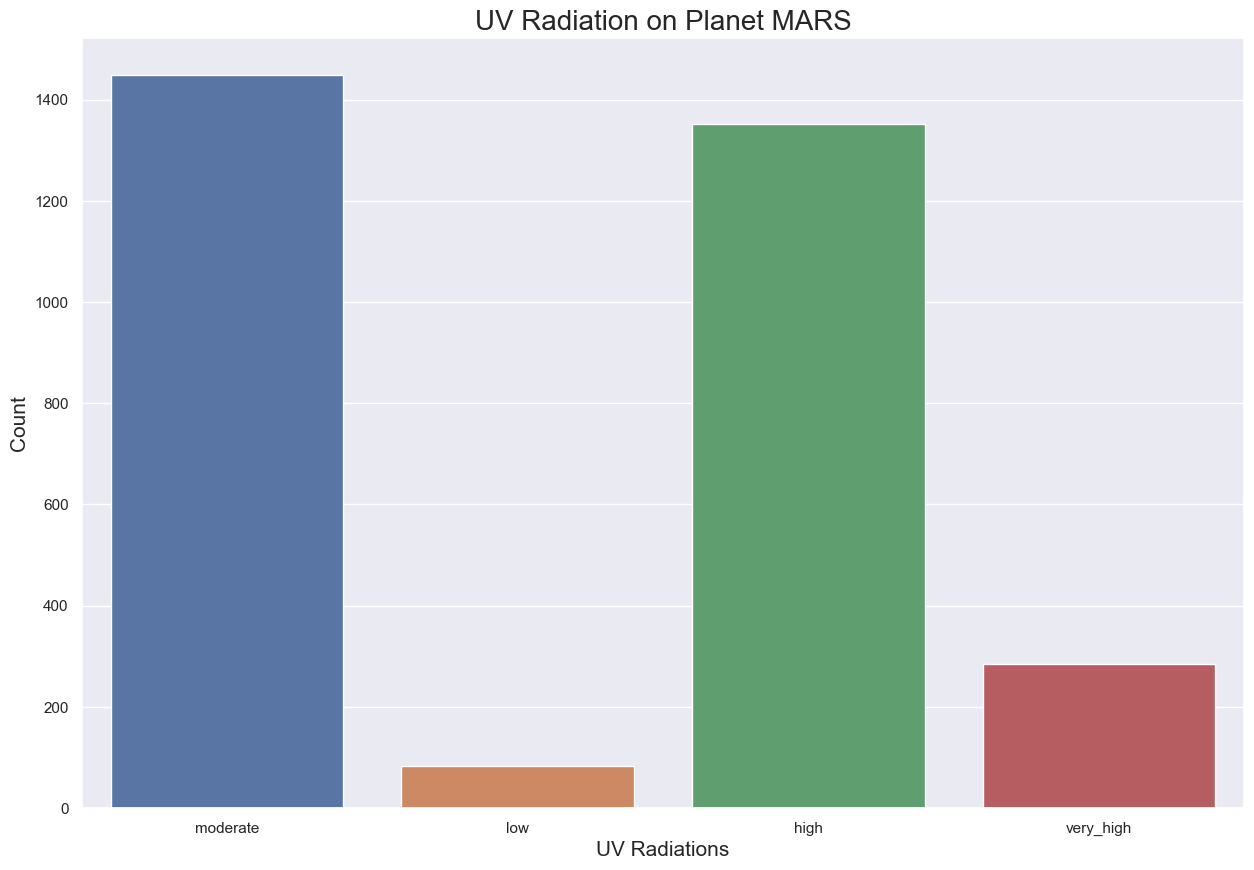

In [34]:
#set the figure size
sns.set(rc={'figure.figsize': (15, 10)})

# A countplot for the data
plt.title("UV Radiation on Planet MARS", fontsize=20)
sns.countplot(data=df, x='UV_Radiation')
plt.ylabel('Count', fontsize=15)
plt.xlabel('UV Radiations', fontsize=15)
plt.show();

* Given that the UV Radiation level is moderate, more than the rest showed a more than 40% chances of having a moderate UV Radiation level at any future date, although this may not be always the case as there is also the high UV Radiation level.

### SOLAR LONGITUDE, SEASONS, SUNLIGHTS ETC

* plot the relationship between solar longitude, sunlight duration as well as the seasons

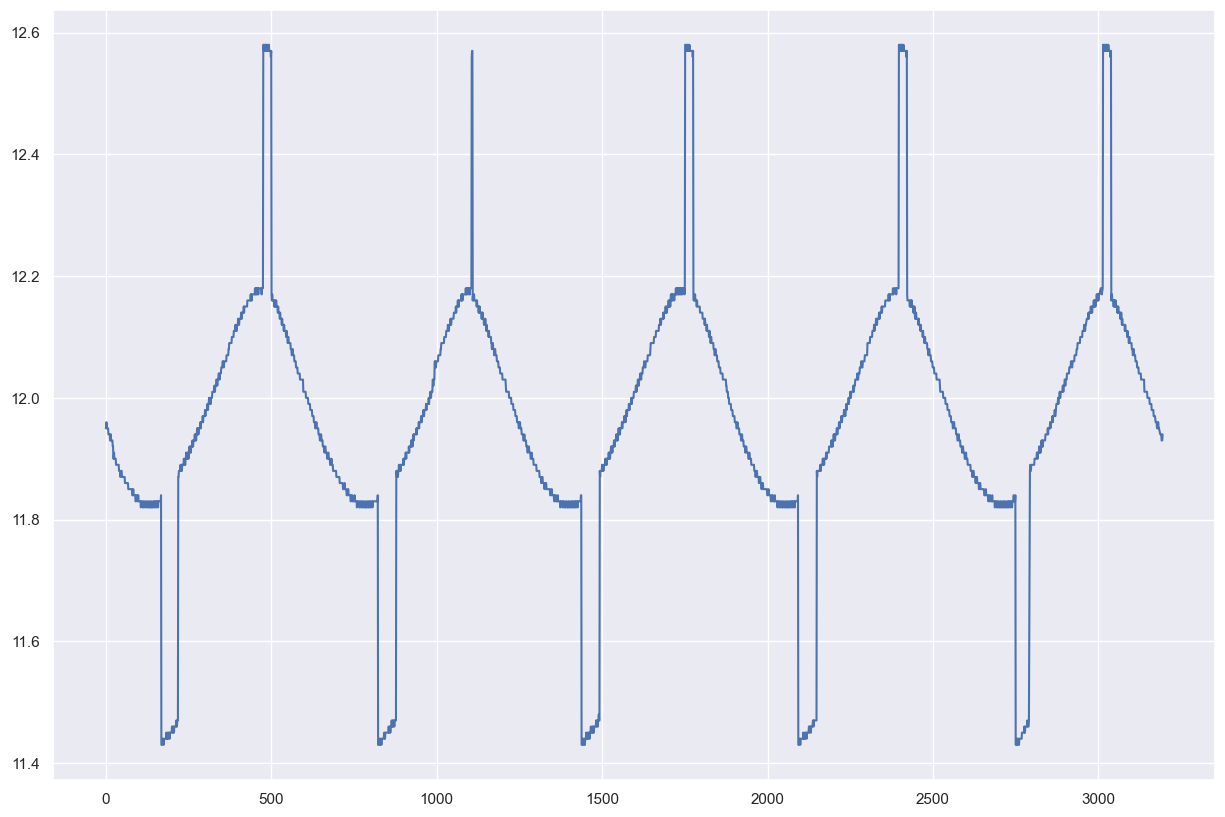

In [35]:
#plot the sunlight duration
plt.plot(df['sunlight_duration']);

* An upside-down funnel shaped plot showing consistency across the years for the sunlight duration, which signifies a predictable amount of sunlights available on the planet.
* Given this observable pattern, it is very much predictable than that of earth.

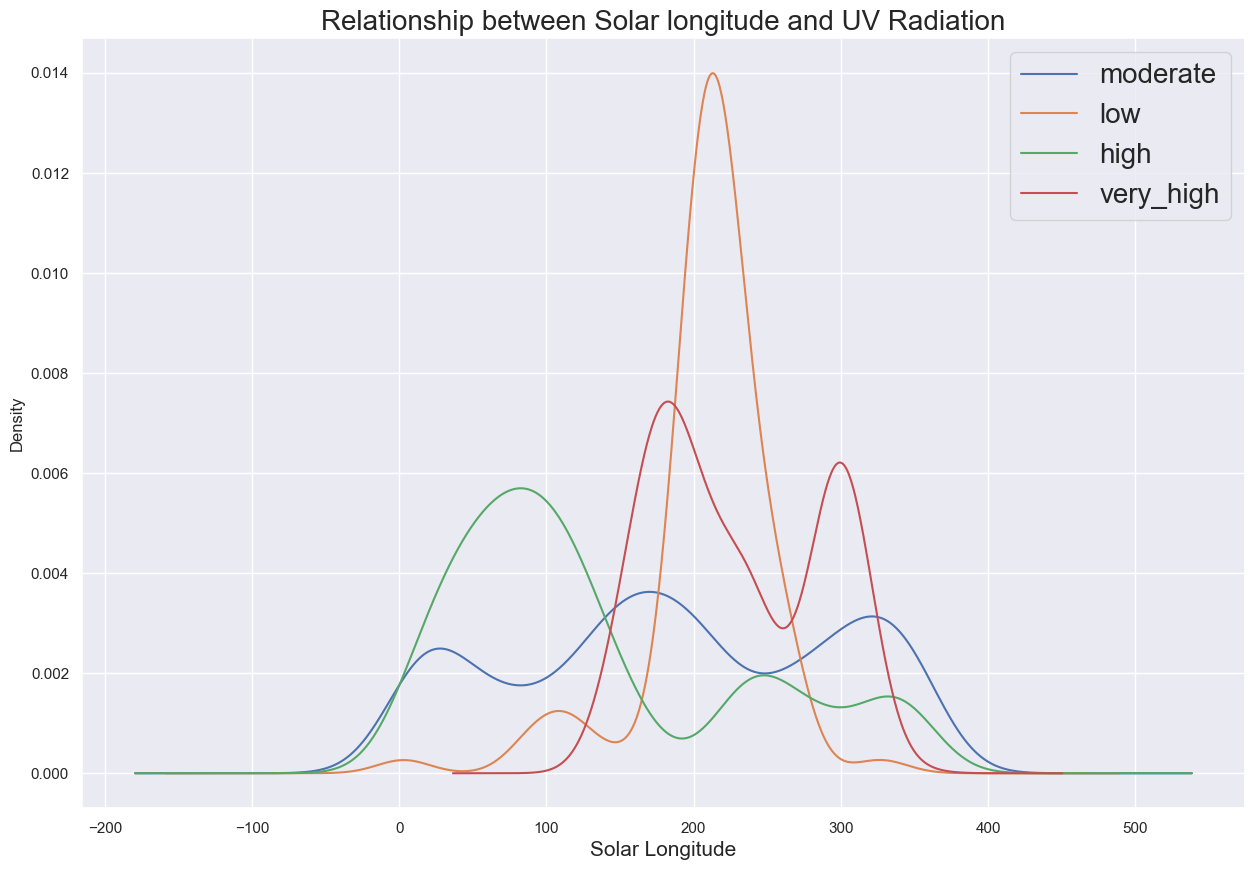

In [36]:
#plot the relationship
plt.title('Relationship between Solar longitude and UV Radiation', fontsize=20)
df.groupby('UV_Radiation')['ls'].plot(kind='kde')
plt.legend(df['UV_Radiation'].unique(), fontsize=20)
plt.xlabel('Solar Longitude', fontsize=15)
plt.show()

* Sudden spikes in very high and low levels of UV radiation was noticed during the sol period of 100 and 300, before every of the levels depicted a steady pattern towards the end of the plot.
* The sudden spikes could be as a result of some abnormal occurences that might have taken place during the logitudinal solar periods of 100 and 300.

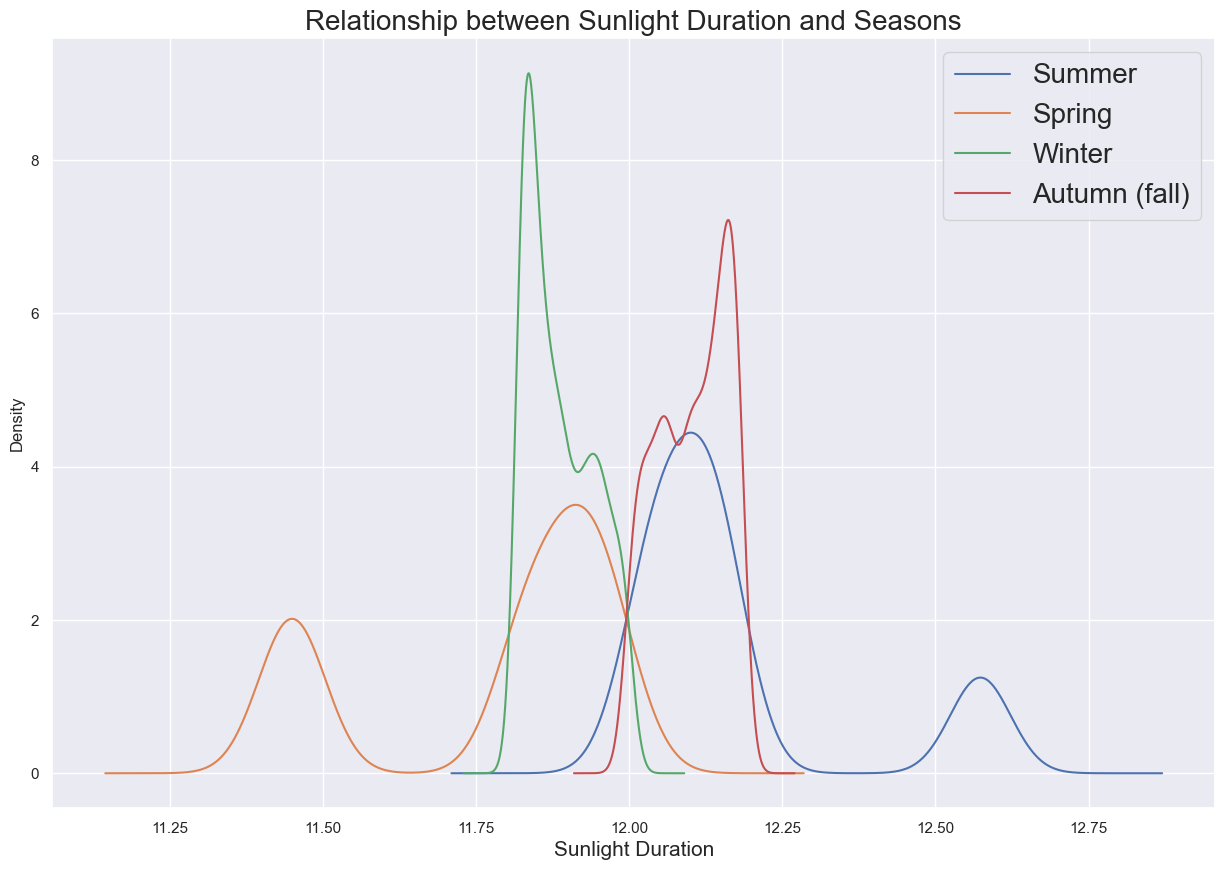

In [37]:
#plot the relationship
plt.title('Relationship between Sunlight Duration and Seasons', fontsize=20)
df.groupby('seasons')['sunlight_duration'].plot(kind='kde')
plt.legend(df['seasons'].unique(), fontsize=20)
plt.xlabel('Sunlight Duration', fontsize=15)
plt.show()

* From the plot, the sunlight duration for winter and autumn showed a predictable range of between 11.75 to 12.25 sunlight duration and the intersection of all the seasons on 12.00 duration is an indication of the possibility of a 12 hours sunlight duration on the planet.

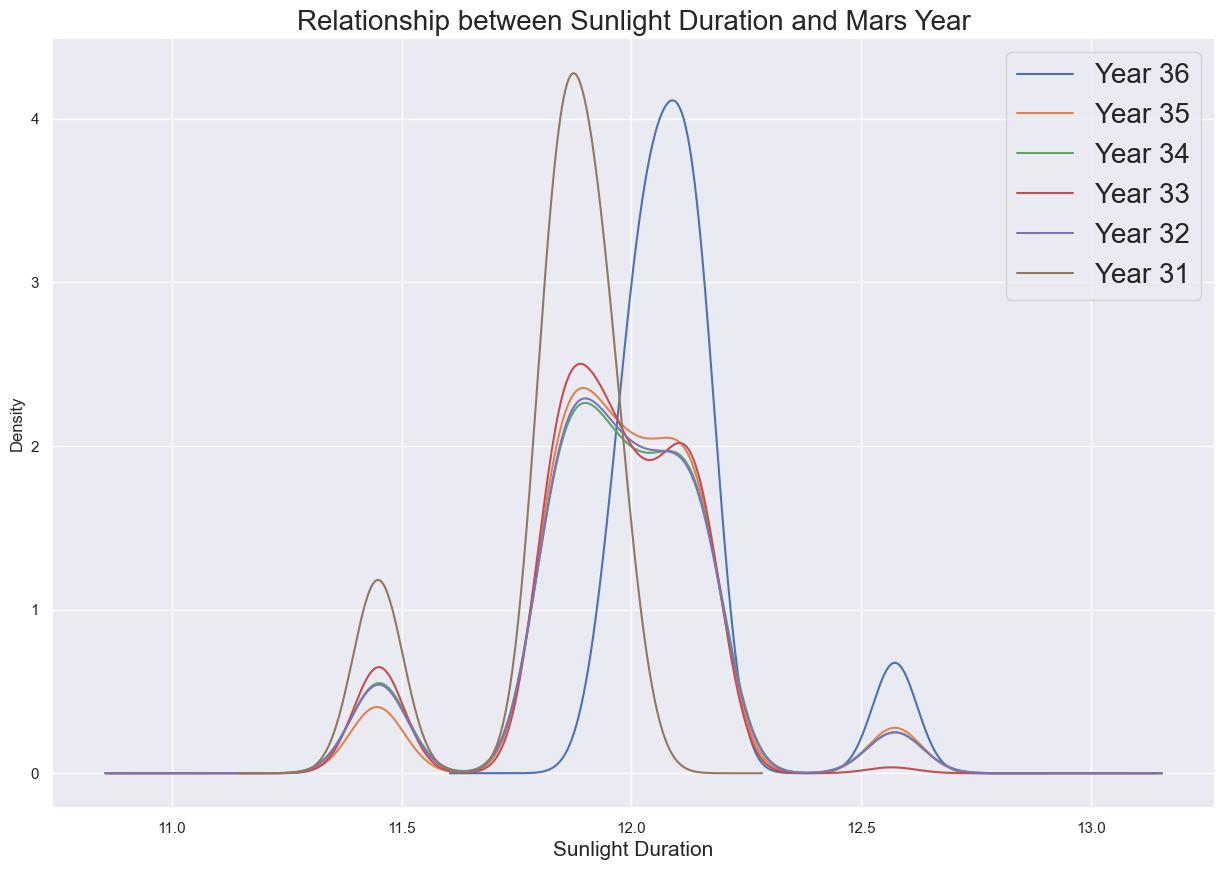

In [38]:
#plot the relationship
plt.title('Relationship between Sunlight Duration and Mars Year', fontsize=20)
df.groupby('mars_year')['sunlight_duration'].plot(kind='kde')
plt.legend(df['mars_year'].unique(), fontsize=20)
plt.xlabel('Sunlight Duration', fontsize=15)
plt.show()

* From the plot, the whole years covered failrly had close to 12 hours at optimum levels and one of the years had a little bit more, while the mars year 31 and 36 stood out as the years with the highest duration of sunlight.

### PREDICTION MODELLING

#### TEMPRATURE

* Given that the ground temperature is a good way to measure the suitable temperature that will support life, while the air temperature helps to determine the likelihood of a change in weather conditions, the two will be used to ascertain and predict temperature on planet mars

#### DATA PREPARATION

* The data needs to first scaled, which reduces data weight that has no significant impact on the data vice versa,
* AFter scaling and preprocessing, the data would be then modelling.

* **Create a new dataframe object**

In [39]:
# new df
new_df = pd.DataFrame(df[['earth_date', 'min_ground_temp(°C)', 'max_ground_temp(°C)', 'min_air_temp(°C)', 'max_air_temp(°C)']])
new_df.set_index('earth_date', inplace=True)
new_df.head()

,min_ground_temp(°C),max_ground_temp(°C),min_air_temp(°C),max_air_temp(°C)
earth_date,,,,
2022-01-26,-71,-3,-84,10
2022-01-25,-72,-3,-87,10
2022-01-24,-70,-4,-81,8
2022-01-23,-70,-6,-91,9
2022-01-22,-71,-7,-92,8


* Define the preprocessing and scaling

In [40]:
# For a daily prediction
new_df_daily = new_df.resample('D').mean()
new_df_daily.head()

,min_ground_temp(°C),max_ground_temp(°C),min_air_temp(°C),max_air_temp(°C)
earth_date,,,,
2012-08-16,-75.0,-16.0,-83.0,8.0
2012-08-17,-76.0,-11.0,-83.0,9.0
2012-08-18,-76.0,-18.0,-82.0,8.0
2012-08-19,-74.0,-15.0,-80.0,8.0
2012-08-20,-74.0,-16.0,-82.0,9.0


* Given that this a time series analysis, a daily resampling can likely introduce empty data (better known as NaN) into the dataset, to ascertain if there is any using .isna().sum() on the dataset

* As was projected to likely occur, to fix this, apply a fillna function that uses the mean of each of the columns 

In [41]:
new_df_daily.isna().sum()

min_ground_temp(°C)    283
max_ground_temp(°C)    283
min_air_temp(°C)       283
max_air_temp(°C)       283
dtype: int64

In [42]:
#fill with 0 for days with no data
for col in new_df_daily.columns:
    new_df_daily.fillna(0, inplace=True)

# check if the processing worked
new_df_daily.isna().sum()

min_ground_temp(°C)    0
max_ground_temp(°C)    0
min_air_temp(°C)       0
max_air_temp(°C)       0
dtype: int64

* The scaler functions scales the selected data.
* The preprocessor on the other hand, resamples the data, and uses the scaling function to generate the new scaled data

In [43]:
# usimg minmax scaler, given the large differences in the temperature results

def scaling(data, original_data=None, direction='direct'):
    # this import should only come when this function is called
    from sklearn.preprocessing import MinMaxScaler
    
    #set the scaler
    scaler=MinMaxScaler(feature_range=(-1,1))
    
    #apply the scaling
    if direction == 'inverse':
        _ = scaler.fit_transform(original_data)
        new_data = scaler.inverse_transform(data)
    else:
        _ = scaler.fit_transform(original_data)
        new_data = scaler.fit_transform(data)
    
    return new_data

def preprocessor(data, sampling='D'):
    new_d = data.resample(sampling).mean()
    
    for col in data.columns:
        new_d[col].fillna(data[col].mean(), inplace=True)
        new_d[col] = new_d[col].astype('float32')
        
    #scale the data
    new_d = scaling(new_d, new_df)
    
    return new_d

In [44]:
#daily data
new_df_daily = preprocessor(new_df)
new_df_daily

array([[ 4.1666985e-02,  3.0769238e-01, -1.7187500e-01,  6.2352943e-01],
       [ 2.3841858e-07,  4.3589750e-01, -1.7187500e-01,  6.4705884e-01],
       [ 2.3841858e-07,  2.5641033e-01, -1.5625000e-01,  6.2352943e-01],
       ...,
       [ 2.5000024e-01,  6.1538470e-01, -1.4062500e-01,  6.2352943e-01],
       [ 1.6666698e-01,  6.4102572e-01, -2.3437500e-01,  6.7058825e-01],
       [ 2.0833349e-01,  6.4102572e-01, -1.8750000e-01,  6.7058825e-01]],
      dtype=float32)

* Set up the data generator using a time step of 1 as default.

In [45]:
def createData(data, look_back=1):
    x_data, y_data = [], []
#     data = np.asanyarray(data)
    for i in range(len(data)-look_back-1):
        x = data[i:(i+look_back), :]
        y = data[i+look_back, :]
        x_data.append(x)
        y_data.append(y)
        
    return np.array(x_data), np.array(y_data)

def splitData(data, look_back=1):
    #split the data into train and test
    #train size of 80%, test size of 20%
    train_size = int(len(data) * .8)
    
    #perform the split using list slicing
    train_data = data[:train_size, :]
    test_data = data[train_size:, :]
    
    #using the specified time step
    x_train, y_train = createData(train_data, look_back=look_back)
    x_test, y_test = createData(test_data, look_back=look_back)
    
    #reshape x train and x test data to reflect (samples, time steps, and features) 
#     x_train = np.reshape(x_train, (x_train.shape[0], 1, 4))
#     x_test = np.reshape(x_test, (x_test.shape[0], 1, 4))
    
    return x_train, y_train, x_test, y_test

In [46]:
#using a higher look back e.g. 10
x_train, y_train, x_test, y_test = splitData(new_df_daily, look_back=10)
x_train[0]

array([[ 4.1666985e-02,  3.0769238e-01, -1.7187500e-01,  6.2352943e-01],
       [ 2.3841858e-07,  4.3589750e-01, -1.7187500e-01,  6.4705884e-01],
       [ 2.3841858e-07,  2.5641033e-01, -1.5625000e-01,  6.2352943e-01],
       [ 8.3333492e-02,  3.3333340e-01, -1.2500000e-01,  6.2352943e-01],
       [ 8.3333492e-02,  3.0769238e-01, -1.5625000e-01,  6.4705884e-01],
       [-8.3333015e-02,  3.3333340e-01, -1.5625000e-01,  6.2352943e-01],
       [-4.1666508e-02,  7.1794879e-01, -1.4062500e-01,  6.4705884e-01],
       [ 2.3841858e-07,  6.1538470e-01, -1.4062500e-01,  6.0000002e-01],
       [ 4.1035652e-02,  3.7937072e-01, -1.2996173e-01,  4.8260552e-01],
       [ 4.1035652e-02,  3.7937072e-01, -1.2996173e-01,  4.8260552e-01]],
      dtype=float32)

In [47]:
#shape
x_train.shape

(2749, 10, 4)

### MODEL ARCHITECTURE STRUCTURE

**Overview**

The neural network architecture consists of a visible LSTM hidden layers with 256 blocks (neurons) each, a RepeatVector that will take the first shape of the data input shape, a Bidirectional LSTM layer, a DENSE layer with 64 blocks and an output layer that predicts a four temperature values (minimum and maximum ground level temperature, minimum and maximum air temperature).

* **Dense** - The regular densely-connected NN layer. <br>
*Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).* **(source -> Docstring)**
* **RepeatVector** - Repeats the input n times.
* **LSTM** - Implement some hidden layers here, and also beased on available runtime hardware and constraints, this layer will choose different implementations (cuDNN-based or pure-TensorFlow) to maximize the performance.
* **Bidirectional** - Bidirectional wrapper for RNNs.

*Extra Parameters*

* **Adam optimizer** - Optimizer that implements the Adam algorithm. <br>
*Adam optimization is a stochastic gradient descent method that is based on
adaptive estimation of first-order and second-order moments.*
* **Accuracy metrics** - Calculates the level of accuracy of the prediction.

<br>

**General notice**

* Time series analysis had undergone so much development, and this development birthed LSTM (Long-Short Term Memory) and this RNN had been a major breakthrough in the field of deep learning, so i will be using it in this modelling.

In [48]:
def temperature_model(input_shape=(1,1)):
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape))
    model.add(rv(input_shape[0]))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(Bidirectional(LSTM(128, activation='relu')))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(input_shape[1]))
    
    model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    
    return model

In [49]:
# initialze the model using an input shape of 5 timesteps and 4 features
model = temperature_model(input_shape=x_train.shape[1:])

In [50]:
#previous training showed that 10 epochs is the optimum level the model should be trained to avoid model overfitting
history1 = model.fit(x_train,y_train,epochs=10, validation_split=0.2)

Epoch 1/10
69/69 [==============================] - 21s 134ms/step - loss: 0.0193 - accuracy: 0.7285 - val_loss: 0.0085 - val_accuracy: 0.8818
Epoch 2/10
69/69 [==============================] - 7s 103ms/step - loss: 0.0090 - accuracy: 0.7913 - val_loss: 0.0082 - val_accuracy: 0.8927
Epoch 3/10
69/69 [==============================] - 7s 103ms/step - loss: 0.0082 - accuracy: 0.7990 - val_loss: 0.0073 - val_accuracy: 0.9018
Epoch 4/10
69/69 [==============================] - 7s 104ms/step - loss: 0.0081 - accuracy: 0.8195 - val_loss: 0.0072 - val_accuracy: 0.9055
Epoch 5/10
69/69 [==============================] - 7s 103ms/step - loss: 0.0082 - accuracy: 0.8213 - val_loss: 0.0070 - val_accuracy: 0.9073
Epoch 6/10
69/69 [==============================] - 7s 104ms/step - loss: 0.0076 - accuracy: 0.8226 - val_loss: 0.0069 - val_accuracy: 0.8927
Epoch 7/10
69/69 [==============================] - 7s 105ms/step - loss: 0.0078 - accuracy: 0.8158 - val_loss: 0.0081 - val_accuracy: 0.8582
Epoch

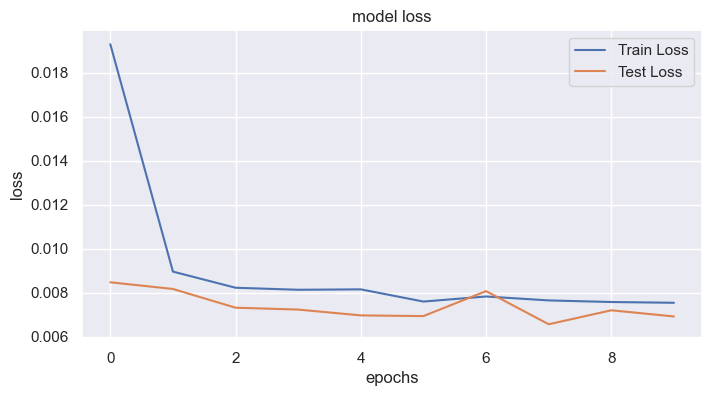

In [51]:
#plot first model losses
plt.figure(figsize=(8,4))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

* The plot showed the models' performance at different epochs

In [52]:
# define a predicted data normalizer

def normalize_result(data):
    data = scaling(data, new_df, direction='inverse')
    return data

In [53]:
# predict with the model
y_pred = model.predict(x_test)
y_pred

22/22 [==============================] - 2s 34ms/step


array([[ 0.23824303,  0.50560695,  0.02701442,  0.4556331 ],
       [ 0.15002836,  0.46390998, -0.03050467,  0.48907834],
       [ 0.20882793,  0.5080203 ,  0.01018482,  0.47469127],
       ...,
       [ 0.15674366,  0.530844  , -0.19696237,  0.627515  ],
       [ 0.16614337,  0.5410697 , -0.21535152,  0.6477547 ],
       [ 0.18242145,  0.55637455, -0.1767294 ,  0.6397278 ]],
      dtype=float32)

In [54]:
#normalize the output
y_pred = normalize_result(y_pred)
y_pred

array([[-70.282166 ,  -8.281329 , -70.27108  ,   0.8644069],
       [-72.39932  ,  -9.90751  , -73.9523   ,   2.2858295],
       [-70.98813  ,  -8.187209 , -71.348175 ,   1.674379 ],
       ...,
       [-72.23815  ,  -7.2970853, -84.60559  ,   8.169388 ],
       [-72.01256  ,  -6.8982825, -85.7825   ,   9.029575 ],
       [-71.62189  ,  -6.3013926, -83.310684 ,   8.68843  ]],
      dtype=float32)

In [55]:
#normalize test data
test_data = normalize_result(y_test)
test_data

array([[-7.5015144e+01, -1.3204541e+01, -8.0317551e+01,  2.0107346e+00],
       [-6.8999992e+01, -6.9999967e+00, -6.9000000e+01,  1.0000013e+00],
       [-6.8999992e+01, -4.9999967e+00, -3.0000000e+01,  1.4305116e-06],
       ...,
       [-7.0000000e+01, -5.9999967e+00, -9.1000000e+01,  9.0000010e+00],
       [-7.0000000e+01, -3.9999969e+00, -8.1000000e+01,  8.0000010e+00],
       [-7.1999992e+01, -2.9999969e+00, -8.7000000e+01,  1.0000001e+01]],
      dtype=float32)

In [56]:
#model evaluation
result = np.sqrt(mse(test_data, y_pred))
print('Model RMSE ->', round(result, 0))

Model RMSE -> 5.0


* with a RMSE score of 5.0, the model can predict efficiently the range of temperature on mars

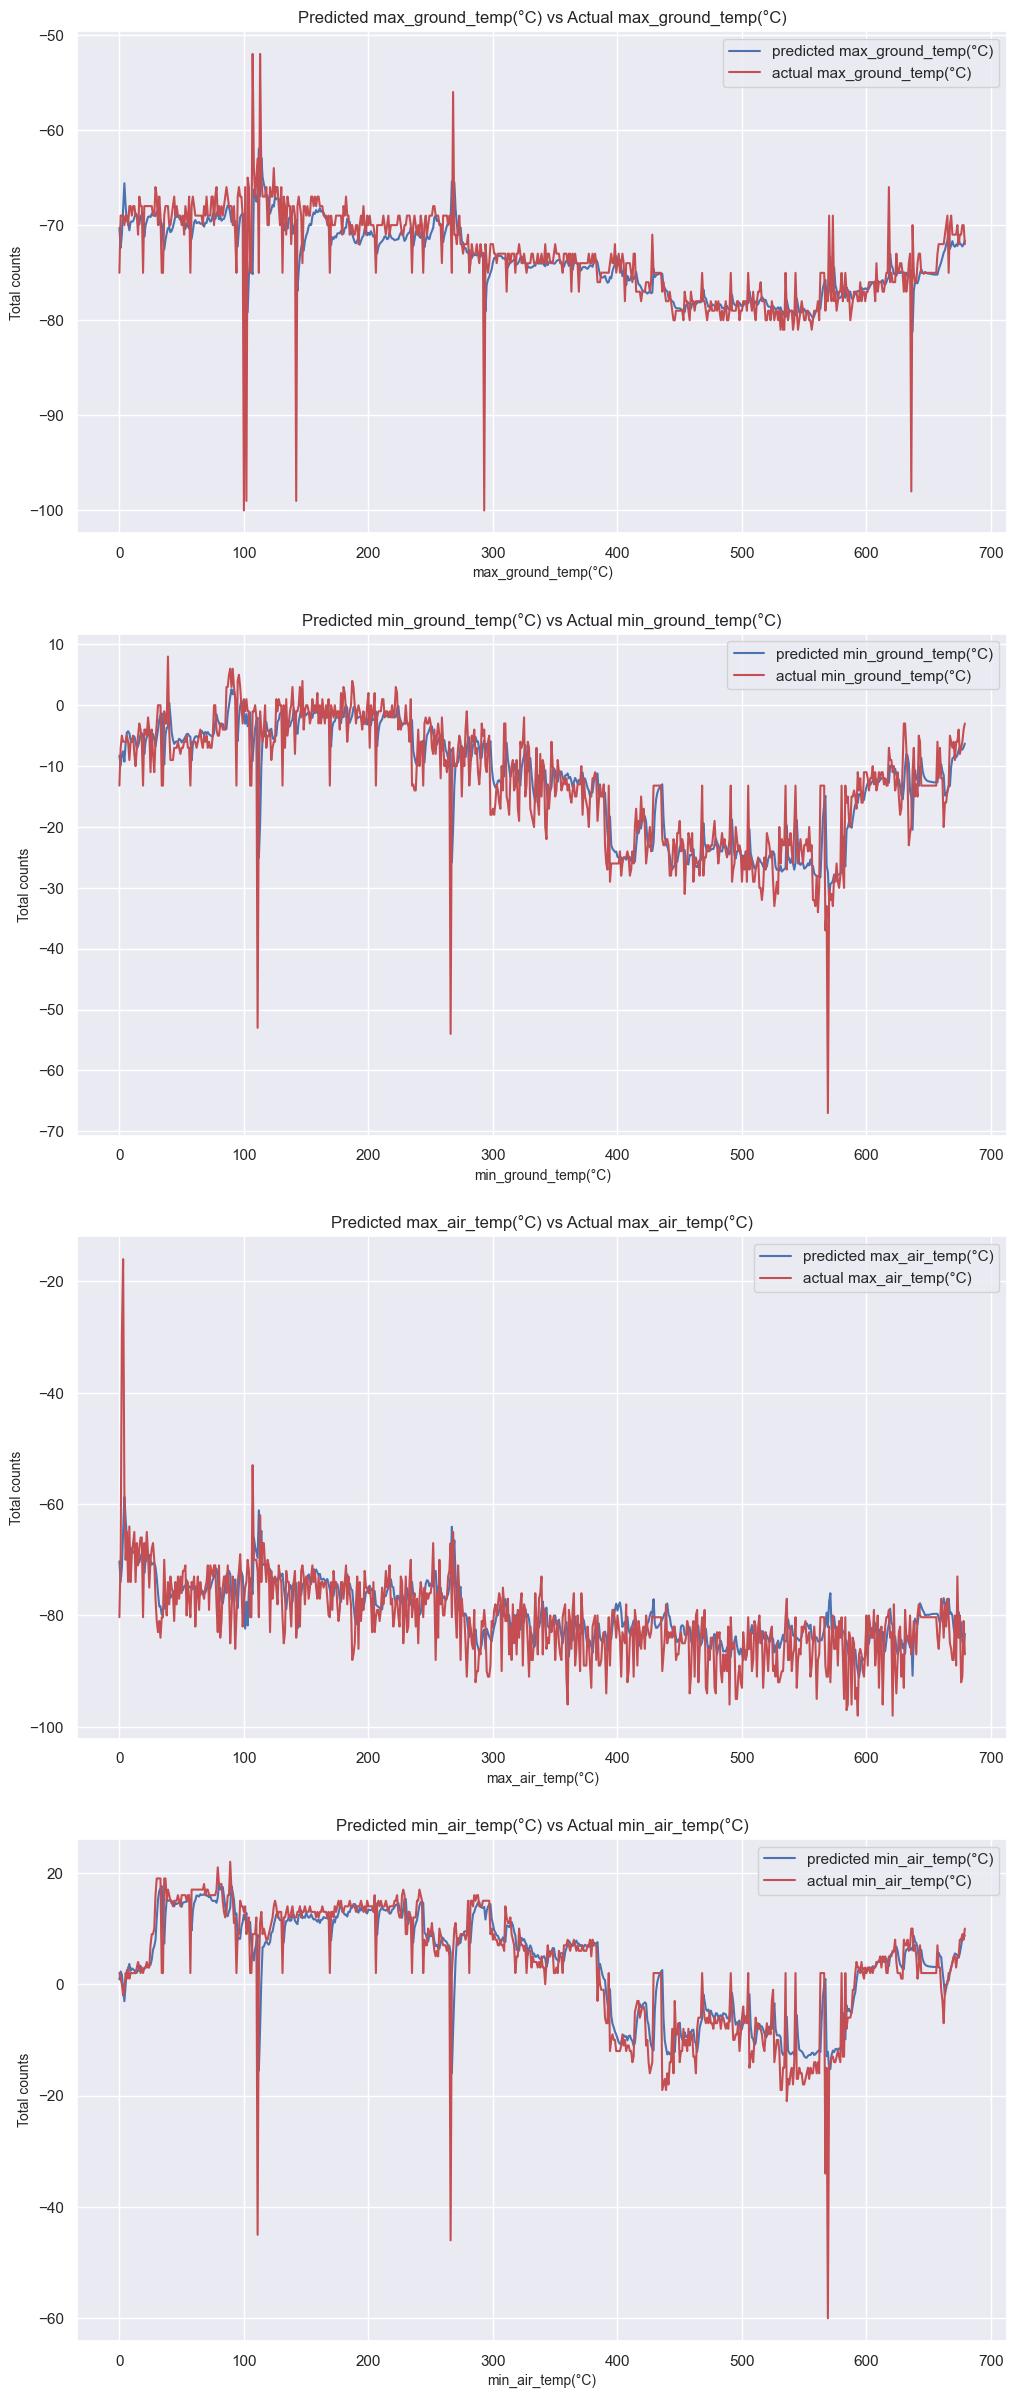

In [57]:
#plot the predicted result vs the actual data
cols = df.columns[4:8]
_, axs = plt.subplots(4, 1, figsize=(12, 30))
axs = axs.ravel()
for i, col in enumerate(cols):
    x = []
    y = []
    for j in range(len(y_pred)):
        x.append(y_pred[j][i])
        y.append(test_data[j][i])
    # set the ticks to be empty
    axs[i].set_xlabel(f'{col}', fontsize=10)
    axs[i].set_ylabel("Total counts", fontsize=10)
    
    #plot the data
    axs[i].plot(x, 'b', label=f'predicted {col}')
    axs[i].plot(y, 'r', label=f'actual {col}')
    axs[i].set_title(f'Predicted {col} vs Actual {col}')
    axs[i].legend()
    
plt.show();

* From the plots, the model did not predict sudden swings in the different temperature parameters, but did well in predicting common occurences.

### MODEL TEST

In [58]:
#predicting temperature pipeline

def predict_temperature(days=1, temperature_today=None):
    cols = ['min_air_temp(°C)', 'max_air_temp(°C)', 'min_ground_temp(°C)', 'max_ground_temp(°C)']
    if temperature_today is None:
        number = -days
        last_data = new_df[cols].values[number:]
        #scale and reshape the data
        actual = scaling(last_data, new_df)
        actual = actual.reshape(actual.shape[0], 1, actual.shape[1])
        pred = model.predict(actual)
        #normalize the prediction
        pred = normalize_result(pred)
    else:
        actual = scaling(temperature_today, new_df)
        actual = actual.reshape(actual.shape[0], 1, actual.shape[1])
        pred = model.predict(actual)
        #normalize the prediction
        pred = normalize_result(pred)
        
    return pred

In [59]:
#predict 27th and 28th of January 2022
predict_temperature(days=2)

1/1 [==============================] - 2s 2s/step


array([[-83.092735 , -13.42001  , -99.87088  ,   6.7178864],
       [-80.24798  , -29.590025 , -74.33974  , -13.7087755]],
      dtype=float32)

In [60]:
#predict 24th of June 2023, by providing the data for 23rd of June

# Currently available is ground temperature on mars, so i will use random data for air temperature, 

# source (https://mars.nasa.gov/msl/weather/)
result = predict_temperature(days=1, temperature_today=[[-80, -27, -14, -3]])
print('Mars Ground Temp Prediction')
print('Low Temp', '\t', 'High Temp')
print(result[0][:2])

1/1 [==============================] - 0s 31ms/step
Mars Ground Temp Prediction
Low Temp 	 High Temp
[-82.6687   -31.026163]


<img src='.\mars temperature.jpg'>

source (https://mars.nasa.gov/msl/weather/)

* The actual result on their website is shown in the image above

#### UV RADIATION

* Given the prediction of the temperature, predicting UV Radiation will be necessary. 
<br>
* The modeling here will utilize the same model used previously, but this time the normalisation would be different.

In [61]:
#create a new data subset
new_df2 = pd.DataFrame(df[['earth_date', 'min_ground_temp(°C)', 'max_ground_temp(°C)', 'min_air_temp(°C)', 'max_air_temp(°C)', 'UV_Radiation']])
new_df2.set_index('earth_date', inplace=True)
new_df2.head()

,min_ground_temp(°C),max_ground_temp(°C),min_air_temp(°C),max_air_temp(°C),UV_Radiation
earth_date,,,,,
2022-01-26,-71,-3,-84,10,moderate
2022-01-25,-72,-3,-87,10,moderate
2022-01-24,-70,-4,-81,8,moderate
2022-01-23,-70,-6,-91,9,moderate
2022-01-22,-71,-7,-92,8,moderate


In [62]:
#preview value count
new_df2['UV_Radiation'].value_counts()

UV_Radiation
moderate     1449
high         1351
very_high     284
low            84
Name: count, dtype: int64

* Given that the number of very high and low radiation is low compared to moderate and high UV Radiation total, they will be renamed to their closest relatives.

In [63]:
# replace the low counts with the mainstream
replace = {'very_high':'high', 'low':'moderate'}
for key, value in replace.items():
    new_df2['UV_Radiation'] = new_df2['UV_Radiation'].replace(key, value, regex=True)

In [64]:
#preview value count
new_df2['UV_Radiation'].value_counts()

UV_Radiation
high        1635
moderate    1533
Name: count, dtype: int64

* Use ONEHOTENCODING to convert the categorical data to Numerical, but the whole processing from conversion to splitting of data will be done in a function called uv_preprocessing.

In [65]:
#initialize the encoder
encoder = OneHotEncoder(handle_unknown='ignore')
#initialize the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

def uv_preprocessing(data):    
    #scale the temperature data
    x_data = scaler.fit_transform(data.drop('UV_Radiation', axis=1))
  
    #encode the data
    y_data = encoder.fit_transform(data[['UV_Radiation']]).toarray()
    
    # convert to numpy array
    y_data = np.array(y_data)
    
    # split the data into 75% training and 25% testing
    train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.25, random_state=42)
    
    return train_x, test_x, train_y, test_y

In [66]:
x_train, x_test, y_train, y_test = uv_preprocessing(new_df2)
x_train.shape

(2376, 4)

In [69]:
#Using decision tree for model training and prediction
decision_model = DecisionTreeClassifier(random_state=42)
trained_model = decision_model.fit(x_train, y_train)

In [70]:
#predict the result
y_pred2 = trained_model.predict(x_test)

In [71]:
#define model performance evaluator for the radiation prediction

def eval_plot(matrix):
    # Set the figure size
    sns.set(rc={'figure.figsize': (10, 6)})
    lab = ['high', 'moderate']
    ax = sns.heatmap(matrix, annot=True, cmap='Greens', fmt='1g', xticklabels=lab, yticklabels=lab)
    ax.set_title('Confusion Matrix\n\n',fontsize = 14, pad = 10)
    ax.set_xlabel('\nPredicted values',fontsize = 14, labelpad = 10)
    ax.set_ylabel('Actual values ',fontsize = 18, labelpad = 20);
    plt.show;
    
    
def evaluation_function(y_pred, y_test):
    pred = list(map(lambda x : np.argmax(x), y_pred))
    actual = list(map(lambda x : np.argmax(x), y_test))
    
    cfx = confusion_matrix(actual, pred)
    
    return cfx

In [72]:
#evaluat the prediction made
x = evaluation_function(y_pred2, y_test)
print(x)

[[301  93]
 [111 287]]


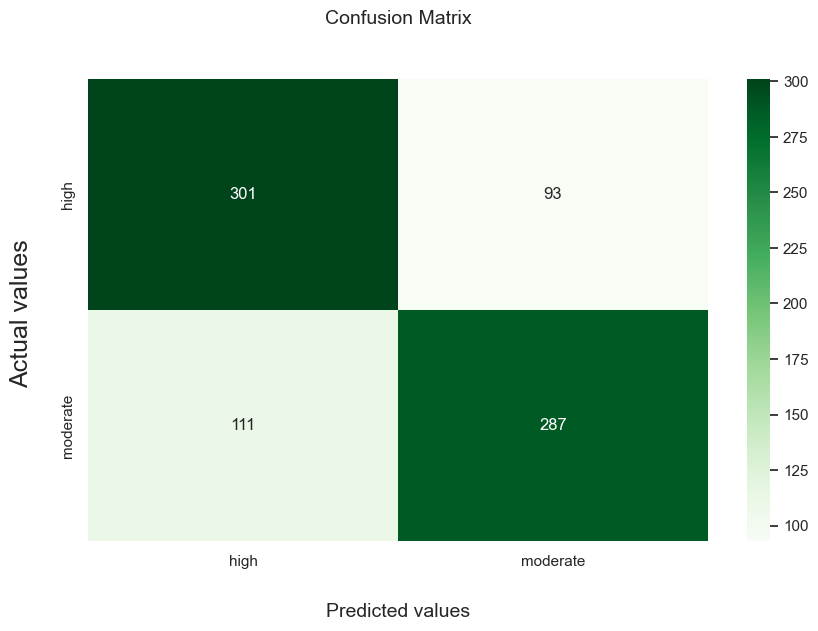

In [73]:
# plot the result
eval_plot(x)

In [74]:
# Preview the model's classification performance
report = classification_report(y_test, y_pred2)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       394
           1       0.76      0.72      0.74       398

   micro avg       0.74      0.73      0.74       792
   macro avg       0.74      0.73      0.74       792
weighted avg       0.74      0.73      0.74       792
 samples avg       0.73      0.73      0.73       792



* Given the f1 score of 74%, the model predicted the result fair enough.

### UV Radiation Prediction 

In [75]:
def uv_predictor(temp):
    if not len(temp.shape) > 1:
        temp = np.array(temp).reshape(1, -1)
    scaled = scaler.transform(temp)
    
    result = {0:'high', 1:'moderate'}
    pred = trained_model.predict(scaled)
    
    pred = list(map(lambda x : np.argmax(x), pred))
    res = list(map(lambda x : result.get(x), pred))
    
    return res

In [76]:
# predict the last 5 provided temp
last_temp = new_df2[new_df2.columns[:-1]].values[-5:]
result = uv_predictor(last_temp)
print(result)

['high', 'moderate', 'high', 'high', 'high']


In [77]:
# while the actual uv radiation
new_df2['UV_Radiation'].values[-5:]

array(['high', 'high', 'high', 'high', 'high'], dtype=object)

* For 5 predictions made, only one is incorrect.

#### RECOMMENDATION

* The dataset used only contains information about planet mars, adn as such a much more recent datasets needs t0 be created.
* To really measure some other weather patterns, there is a need to get relevant dataset means for his crew.
* since this field is an ongoing developmental aspect of data science, there is a need for more research work into